In [1]:
import pandas as pd
import numpy as np
from imblearn.over_sampling import RandomOverSampler
from catboost import CatBoostRegressor
from sklearn.metrics import accuracy_score, classification_report

import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rc('font', family = 'Gulim')
mpl.rcParams['axes.unicode_minus']=False

import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)

In [2]:
train = pd.read_csv("data/train_onehotenc5.csv")
test = pd.read_csv("data/test_onehotenc5.csv")
sub = pd.read_csv("data/sample_submission.csv")

In [3]:
train['상환원금/대출금액'] = train['총상환원금']/train['대출금액']
train['상환이자/대출금액'] = train['총상환이자']/train['대출금액']
train['연체금액/대출금액'] = train['총연체금액']/train['대출금액']
train['상환/대출금액'] = (train["총상환원금"] + train["총상환이자"]) / train["대출금액"]
train['대출금액/계좌수'] = train["대출금액"] / train["총계좌수"]
train['연간소득/대출금액'] = train["연간소득"] / train["대출금액"]
train['상환/연간소득'] = (train["총상환원금"] + train["총상환이자"]) / (train["연간소득"] + 1)
train["대출기간"] = (train["대출기간"] + 1) * 36
train["대출금액/대출기간"] = train["대출금액"] / train["대출기간"]

test['상환원금/대출금액'] = test['총상환원금']/test['대출금액']
test['상환이자/대출금액'] = test['총상환이자']/test['대출금액']
test['연체금액/대출금액'] = test['총연체금액']/test['대출금액']
test['상환/대출금액'] = (test["총상환원금"] + test["총상환이자"]) / test["대출금액"]
test['대출금액/계좌수'] = test["대출금액"] / test["총계좌수"]
test['연간소득/대출금액'] = test["연간소득"] / test["대출금액"]
test['상환/연간소득'] = (test["총상환원금"] + test["총상환이자"]) / (test["연간소득"] + 1)
test["대출기간"] = (test["대출기간"] + 1) * 36
test["대출금액/대출기간"] = test["대출금액"] / test["대출기간"]


In [4]:
mapping_target = {1 : 0, 2 : 1, 3 : 2, 4 : 3, 5 : 4, 6 : 5, 7 : 6}
train["대출등급"] = train["대출등급"].replace(mapping_target)

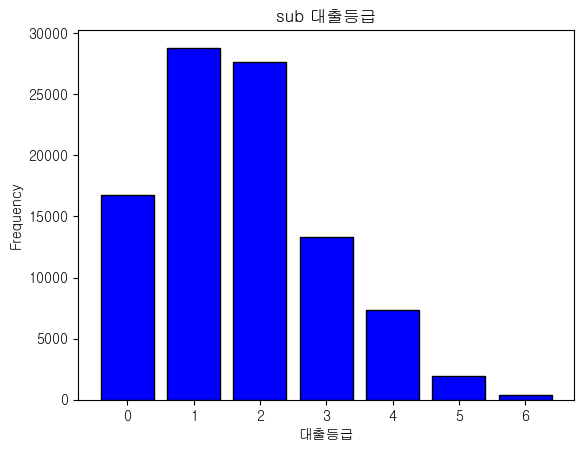

In [5]:
plt.hist(train["대출등급"], bins=range(8), align='left', rwidth=0.8, color='blue', edgecolor='black')

plt.xlabel("대출등급")
plt.ylabel("Frequency")
plt.title("sub 대출등급")
plt.show()

In [6]:
train_36 = train.loc[train["대출기간"] == 36]
train_72 = train.loc[train["대출기간"] == 72]

# 36months

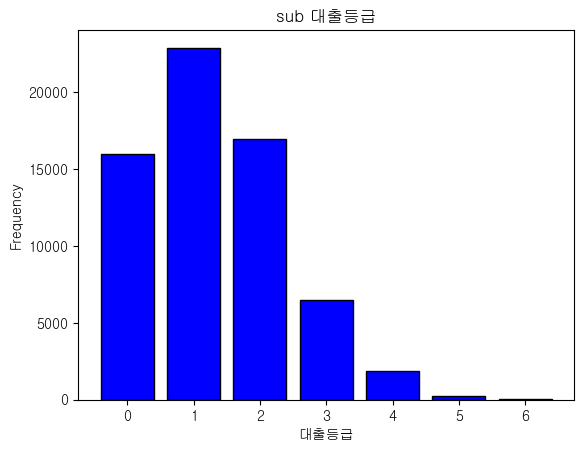

In [7]:
plt.hist(train_36["대출등급"], bins=range(8), align='left', rwidth=0.8, color='blue', edgecolor='black')

plt.xlabel("대출등급")
plt.ylabel("Frequency")
plt.title("sub 대출등급")
plt.show()

# ABC(DEFG)

In [8]:
new_train_1 = train_36.copy()
new_train_1["대출등급"] = new_train_1["대출등급"].apply(lambda x:4 if x == 5 else x)
new_train_1["대출등급"] = new_train_1["대출등급"].apply(lambda x:4 if x == 6 else x)
new_train_1["대출등급"] = new_train_1["대출등급"].apply(lambda x:4 if x == 7 else x)

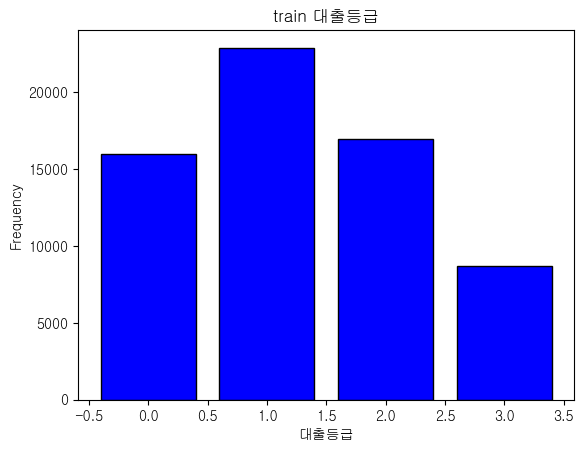

In [9]:
plt.hist(new_train_1["대출등급"], bins=range(5), align='left', rwidth=0.8, color='blue', edgecolor='black')

plt.xlabel("대출등급")
plt.ylabel("Frequency")
plt.title("train 대출등급")
plt.show()

In [10]:
X = new_train_1.drop(columns=['대출등급'])
y = new_train_1[['대출등급']]
cat = CatBoostRegressor()
model_1 = cat.fit(X, y)
pred = model_1.predict(X)

Learning rate set to 0.07908
0:	learn: 1.0004656	total: 145ms	remaining: 2m 24s
1:	learn: 0.9474032	total: 150ms	remaining: 1m 14s
2:	learn: 0.8960983	total: 154ms	remaining: 51.3s
3:	learn: 0.8517976	total: 161ms	remaining: 40.2s
4:	learn: 0.8078454	total: 166ms	remaining: 33.1s
5:	learn: 0.7714533	total: 171ms	remaining: 28.4s
6:	learn: 0.7358034	total: 176ms	remaining: 24.9s
7:	learn: 0.7043471	total: 180ms	remaining: 22.3s
8:	learn: 0.6732566	total: 185ms	remaining: 20.4s
9:	learn: 0.6452308	total: 190ms	remaining: 18.8s
10:	learn: 0.6197575	total: 196ms	remaining: 17.6s
11:	learn: 0.5964320	total: 201ms	remaining: 16.6s
12:	learn: 0.5749819	total: 207ms	remaining: 15.7s
13:	learn: 0.5553948	total: 213ms	remaining: 15s
14:	learn: 0.5385206	total: 219ms	remaining: 14.4s
15:	learn: 0.5223109	total: 225ms	remaining: 13.8s
16:	learn: 0.5085913	total: 231ms	remaining: 13.3s
17:	learn: 0.4951344	total: 235ms	remaining: 12.8s
18:	learn: 0.4836630	total: 240ms	remaining: 12.4s
19:	learn: 0

In [11]:
pred_1 = model_1.predict(test).flatten()
pred_1 = np.round(pred_1)
sub.loc[(sub['대출등급'] == 'G') & (pred_1 == 0) & (test["대출기간"] == 36), "대출등급"] = 0
sub.loc[(sub['대출등급'] == 'G') & (pred_1 == 1) & (test["대출기간"] == 36), "대출등급"] = 1
sub.loc[(sub['대출등급'] == 'G') & (pred_1 == 2) & (test["대출기간"] == 36), "대출등급"] = 2
sub["대출등급"].unique()

array([1, 0, 2, 'G'], dtype=object)

# D(EFG)

In [12]:
new_train_2 = train_36.copy()
new_train_2 = new_train_2[new_train_2["대출등급"] != 0]
new_train_2 = new_train_2[new_train_2["대출등급"] != 1]
new_train_2 = new_train_2[new_train_2["대출등급"] != 2]
new_train_2["대출등급"].unique()

array([3, 4, 5, 6], dtype=int64)

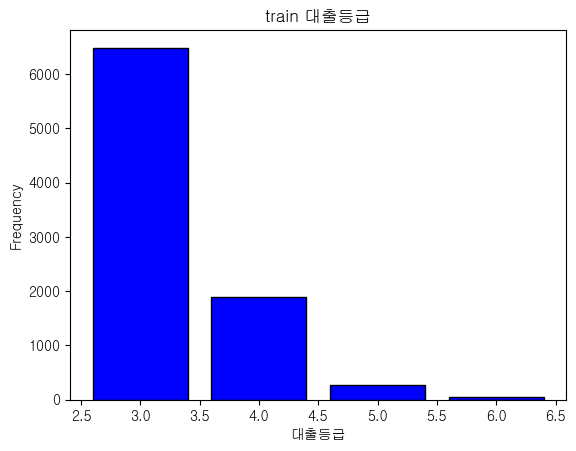

In [13]:
plt.hist(new_train_2["대출등급"], bins=range(3,8), align='left', rwidth=0.8, color='blue', edgecolor='black')

plt.xlabel("대출등급")
plt.ylabel("Frequency")
plt.title("train 대출등급")
plt.show()

In [14]:
new_train_2["대출등급"] = new_train_2["대출등급"].apply(lambda x:0 if x==3 else x)
new_train_2["대출등급"] = new_train_2["대출등급"].apply(lambda x:1 if x==4 else x)
new_train_2["대출등급"] = new_train_2["대출등급"].apply(lambda x:1 if x==5 else x)
new_train_2["대출등급"] = new_train_2["대출등급"].apply(lambda x:1 if x==6 else x)

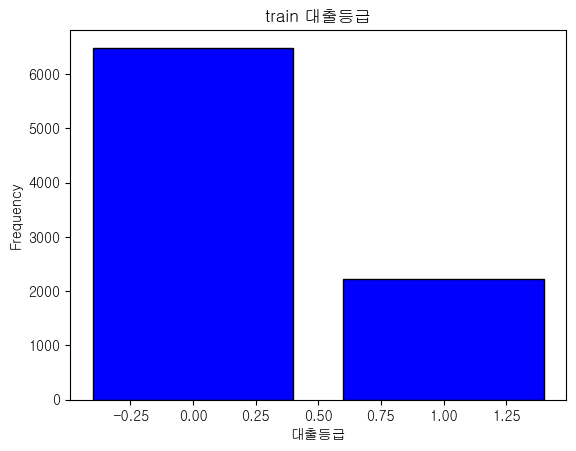

In [15]:
plt.hist(new_train_2["대출등급"], bins=range(3), align='left', rwidth=0.8, color='blue', edgecolor='black')

plt.xlabel("대출등급")
plt.ylabel("Frequency")
plt.title("train 대출등급")
plt.show()

In [16]:
X = new_train_2.drop(columns=['대출등급'])
y = new_train_2[['대출등급']]
os = RandomOverSampler(random_state=42)
X, y = os.fit_resample(X, y)
X.shape, y.shape

((12970, 45), (12970, 1))

In [17]:
cat = CatBoostRegressor()
model_2 = cat.fit(X, y)
pred = model_2.predict(X)

pred_2 = model_2.predict(test).flatten()
pred_2 = np.round(pred_2)
sub.loc[(sub['대출등급'] == 'G') & (pred_2 == 0) & (test["대출기간"] == 36), "대출등급"] = 3
sub["대출등급"].unique()

Learning rate set to 0.06138
0:	learn: 0.4780322	total: 4ms	remaining: 4s
1:	learn: 0.4586062	total: 7.45ms	remaining: 3.72s
2:	learn: 0.4411900	total: 10.7ms	remaining: 3.55s
3:	learn: 0.4238443	total: 14.1ms	remaining: 3.51s
4:	learn: 0.4080552	total: 17.2ms	remaining: 3.41s
5:	learn: 0.3927686	total: 20.9ms	remaining: 3.47s
6:	learn: 0.3798500	total: 24.1ms	remaining: 3.41s
7:	learn: 0.3671456	total: 27.4ms	remaining: 3.4s
8:	learn: 0.3550412	total: 30.4ms	remaining: 3.35s
9:	learn: 0.3415344	total: 33.4ms	remaining: 3.3s
10:	learn: 0.3313282	total: 36.8ms	remaining: 3.31s
11:	learn: 0.3222615	total: 39.8ms	remaining: 3.28s
12:	learn: 0.3111721	total: 42.8ms	remaining: 3.25s
13:	learn: 0.3014222	total: 46.1ms	remaining: 3.24s
14:	learn: 0.2919157	total: 49.6ms	remaining: 3.25s
15:	learn: 0.2832794	total: 52.8ms	remaining: 3.25s
16:	learn: 0.2762435	total: 55.7ms	remaining: 3.22s
17:	learn: 0.2697158	total: 58.9ms	remaining: 3.21s
18:	learn: 0.2645408	total: 61.7ms	remaining: 3.18s
1

array([1, 0, 2, 'G', 3], dtype=object)

# E(FG)

In [18]:
new_train_3 = train_36.copy()
new_train_3 = new_train_3[new_train_3["대출등급"] != 0]
new_train_3 = new_train_3[new_train_3["대출등급"] != 1]
new_train_3 = new_train_3[new_train_3["대출등급"] != 2]
new_train_3 = new_train_3[new_train_3["대출등급"] != 3]
new_train_3["대출등급"].unique()

array([4, 5, 6], dtype=int64)

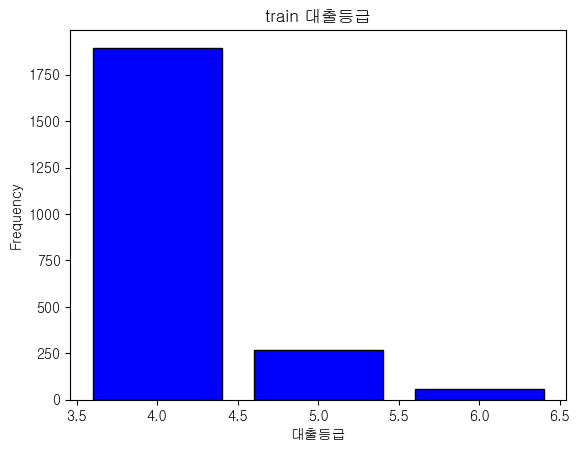

In [19]:
plt.hist(new_train_3["대출등급"], bins=range(4,8), align='left', rwidth=0.8, color='blue', edgecolor='black')

plt.xlabel("대출등급")
plt.ylabel("Frequency")
plt.title("train 대출등급")
plt.show()

In [20]:
new_train_3["대출등급"] = new_train_3["대출등급"].apply(lambda x:0 if x==4 else x)
new_train_3["대출등급"] = new_train_3["대출등급"].apply(lambda x:1 if x==5 else x)
new_train_3["대출등급"] = new_train_3["대출등급"].apply(lambda x:1 if x==6 else x)
new_train_3["대출등급"].unique()

array([0, 1], dtype=int64)

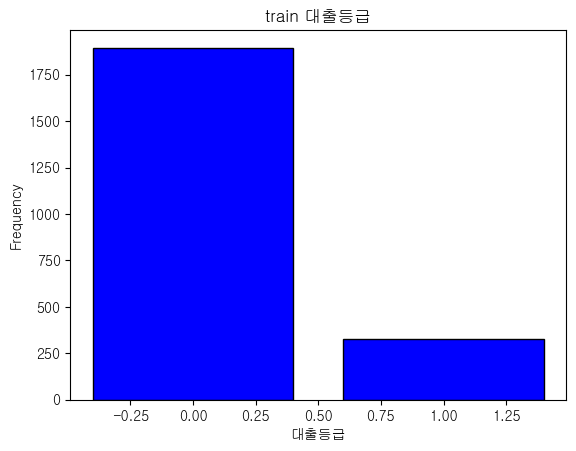

In [21]:
plt.hist(new_train_3["대출등급"], bins=range(3), align='left', rwidth=0.8, color='blue', edgecolor='black')

plt.xlabel("대출등급")
plt.ylabel("Frequency")
plt.title("train 대출등급")
plt.show()

In [22]:
X = new_train_3.drop(columns=['대출등급'])
y = new_train_3[['대출등급']]
os = RandomOverSampler(random_state=42)
X, y = os.fit_resample(X, y)
X.shape, y.shape

((3790, 45), (3790, 1))

In [23]:
cat = CatBoostRegressor()
model_3 = cat.fit(X, y)
pred = model_3.predict(X)

pred_3 = model_3.predict(test).flatten()
pred_3 = np.round(pred_3)
sub.loc[(sub['대출등급'] == 'G') & (pred_3 == 0) & (test["대출기간"] == 36), "대출등급"] = 4
sub["대출등급"].unique()

Learning rate set to 0.050536
0:	learn: 0.4813897	total: 4.01ms	remaining: 4s
1:	learn: 0.4656087	total: 6.91ms	remaining: 3.45s
2:	learn: 0.4498533	total: 9.13ms	remaining: 3.03s
3:	learn: 0.4349006	total: 11.2ms	remaining: 2.79s
4:	learn: 0.4187318	total: 14ms	remaining: 2.78s
5:	learn: 0.4061845	total: 16.2ms	remaining: 2.68s
6:	learn: 0.3918305	total: 18.2ms	remaining: 2.58s
7:	learn: 0.3796643	total: 20.3ms	remaining: 2.52s
8:	learn: 0.3672941	total: 22.5ms	remaining: 2.47s
9:	learn: 0.3554671	total: 24.7ms	remaining: 2.44s
10:	learn: 0.3458130	total: 26.9ms	remaining: 2.42s
11:	learn: 0.3364889	total: 30.2ms	remaining: 2.48s
12:	learn: 0.3257790	total: 32.5ms	remaining: 2.46s
13:	learn: 0.3158777	total: 34.6ms	remaining: 2.44s
14:	learn: 0.3073902	total: 36.8ms	remaining: 2.42s
15:	learn: 0.3002476	total: 39ms	remaining: 2.4s
16:	learn: 0.2916944	total: 41.1ms	remaining: 2.37s
17:	learn: 0.2844044	total: 43.3ms	remaining: 2.36s
18:	learn: 0.2771624	total: 45.9ms	remaining: 2.37s


array([1, 0, 2, 'G', 3, 4], dtype=object)

# FG

In [24]:
new_train_4 = train_36.copy()
new_train_4 = new_train_4[new_train_4["대출등급"] != 0]
new_train_4 = new_train_4[new_train_4["대출등급"] != 1]
new_train_4 = new_train_4[new_train_4["대출등급"] != 2]
new_train_4 = new_train_4[new_train_4["대출등급"] != 3]
new_train_4 = new_train_4[new_train_4["대출등급"] != 4]
new_train_4["대출등급"].unique()

array([5, 6], dtype=int64)

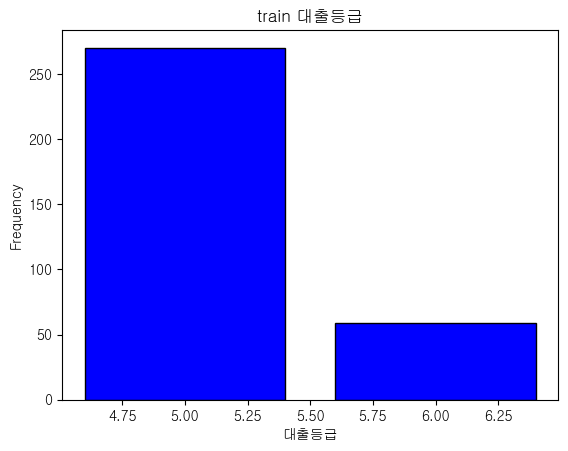

In [25]:
plt.hist(new_train_4["대출등급"], bins=range(5,8), align='left', rwidth=0.8, color='blue', edgecolor='black')

plt.xlabel("대출등급")
plt.ylabel("Frequency")
plt.title("train 대출등급")
plt.show()

In [26]:
new_train_4["대출등급"] = new_train_4["대출등급"].apply(lambda x:0 if x==5 else x)
new_train_4["대출등급"] = new_train_4["대출등급"].apply(lambda x:1 if x==6 else x)
new_train_4["대출등급"].unique()

array([0, 1], dtype=int64)

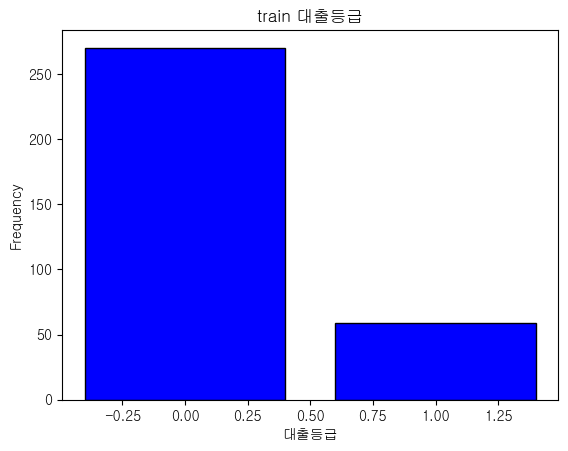

In [27]:
plt.hist(new_train_4["대출등급"], bins=range(3), align='left', rwidth=0.8, color='blue', edgecolor='black')

plt.xlabel("대출등급")
plt.ylabel("Frequency")
plt.title("train 대출등급")
plt.show()

In [28]:
X = new_train_4.drop(columns=['대출등급'])
y = new_train_4[['대출등급']]
os = RandomOverSampler(random_state=42)
X, y = os.fit_resample(X, y)
X.shape, y.shape

((540, 45), (540, 1))

In [29]:
cat = CatBoostRegressor()
model_4 = cat.fit(X, y)
pred = model_4.predict(X)

pred_4 = model_4.predict(test).flatten()
pred_4 = np.round(pred_4)
sub.loc[(sub['대출등급'] == 'G') & (pred_4 == 0) & (test["대출기간"] == 36), "대출등급"] = 5
sub.loc[(sub['대출등급'] == 'G') & (pred_4 == 1) & (test["대출기간"] == 36), "대출등급"] = 6
sub["대출등급"].unique()

Learning rate set to 0.037145
0:	learn: 0.4916171	total: 4.33ms	remaining: 4.32s
1:	learn: 0.4846654	total: 7.95ms	remaining: 3.96s
2:	learn: 0.4784408	total: 10.2ms	remaining: 3.4s
3:	learn: 0.4693724	total: 12.2ms	remaining: 3.03s
4:	learn: 0.4633653	total: 14ms	remaining: 2.79s
5:	learn: 0.4576929	total: 16ms	remaining: 2.66s
6:	learn: 0.4497938	total: 18.2ms	remaining: 2.58s
7:	learn: 0.4402434	total: 19.7ms	remaining: 2.45s
8:	learn: 0.4331676	total: 21.4ms	remaining: 2.35s
9:	learn: 0.4259445	total: 22.9ms	remaining: 2.27s
10:	learn: 0.4195864	total: 24.5ms	remaining: 2.21s
11:	learn: 0.4129875	total: 26.1ms	remaining: 2.15s
12:	learn: 0.4081518	total: 27.6ms	remaining: 2.1s
13:	learn: 0.4033404	total: 29.4ms	remaining: 2.07s
14:	learn: 0.3979037	total: 30.8ms	remaining: 2.02s
15:	learn: 0.3928096	total: 32.1ms	remaining: 1.98s
16:	learn: 0.3864699	total: 34.1ms	remaining: 1.97s
17:	learn: 0.3788146	total: 35.6ms	remaining: 1.94s
18:	learn: 0.3723191	total: 37.2ms	remaining: 1.92

array([1, 0, 2, 'G', 5, 3, 4, 6], dtype=object)

In [30]:
cnt = 0
for i in range(len(sub)):
    if sub.iloc[i,-1] == "G":
        cnt += 1
cnt

20968

# 72 months

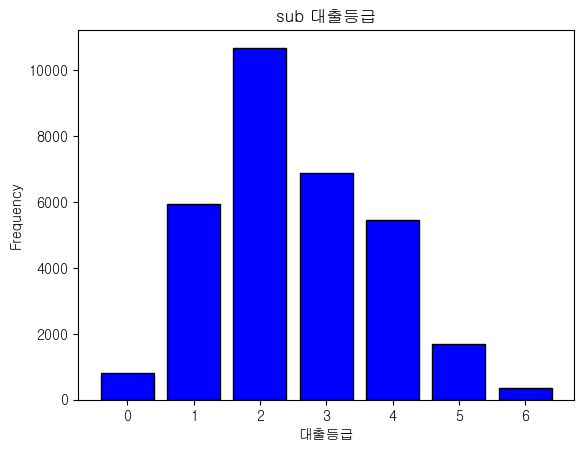

In [31]:
plt.hist(train_72["대출등급"], bins=range(8), align='left', rwidth=0.8, color='blue', edgecolor='black')

plt.xlabel("대출등급")
plt.ylabel("Frequency")
plt.title("sub 대출등급")
plt.show()

# BCDE(AFG)

In [32]:
new_train_1 = train_72.copy()
new_train_1["대출등급"] = new_train_1["대출등급"].apply(lambda x:0 if x == 5 else x)
new_train_1["대출등급"] = new_train_1["대출등급"].apply(lambda x:0 if x == 6 else x)

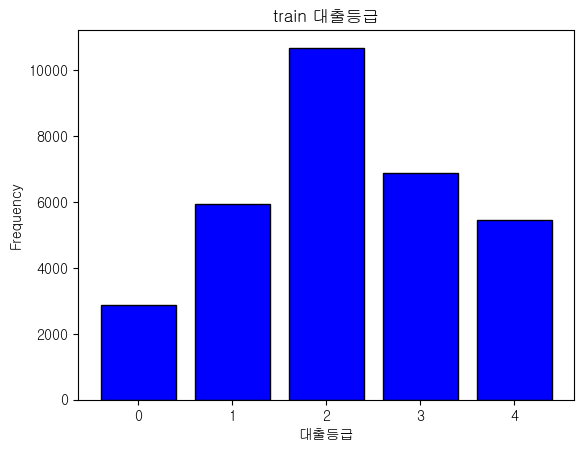

In [33]:
plt.hist(new_train_1["대출등급"], bins=range(6), align='left', rwidth=0.8, color='blue', edgecolor='black')

plt.xlabel("대출등급")
plt.ylabel("Frequency")
plt.title("train 대출등급")
plt.show()

In [34]:
X = new_train_1.drop(columns=['대출등급'])
y = new_train_1[['대출등급']]
cat = CatBoostRegressor()
model_1 = cat.fit(X, y)
pred = model_1.predict(X)

Learning rate set to 0.070729
0:	learn: 1.1478688	total: 5.86ms	remaining: 5.85s
1:	learn: 1.1113900	total: 10.3ms	remaining: 5.12s
2:	learn: 1.0781631	total: 14.7ms	remaining: 4.9s
3:	learn: 1.0461903	total: 19.2ms	remaining: 4.78s
4:	learn: 1.0145304	total: 23.9ms	remaining: 4.76s
5:	learn: 0.9840813	total: 28.2ms	remaining: 4.68s
6:	learn: 0.9601405	total: 32.8ms	remaining: 4.65s
7:	learn: 0.9337267	total: 37.2ms	remaining: 4.61s
8:	learn: 0.9104372	total: 41.6ms	remaining: 4.58s
9:	learn: 0.8842630	total: 45.6ms	remaining: 4.51s
10:	learn: 0.8620139	total: 49.3ms	remaining: 4.44s
11:	learn: 0.8405939	total: 53.5ms	remaining: 4.4s
12:	learn: 0.8225153	total: 58.4ms	remaining: 4.44s
13:	learn: 0.8041412	total: 63ms	remaining: 4.44s
14:	learn: 0.7889979	total: 67.9ms	remaining: 4.46s
15:	learn: 0.7726407	total: 72.6ms	remaining: 4.46s
16:	learn: 0.7553165	total: 76.5ms	remaining: 4.42s
17:	learn: 0.7413277	total: 80.2ms	remaining: 4.38s
18:	learn: 0.7272538	total: 83.8ms	remaining: 4.

In [35]:
pred_1 = model_1.predict(test).flatten()
pred_1 = np.round(pred_1)
sub.loc[(sub['대출등급'] == 'G') & (pred_1 == 1) & (test["대출기간"] == 72), "대출등급"] = 1
sub.loc[(sub['대출등급'] == 'G') & (pred_1 == 2) & (test["대출기간"] == 72), "대출등급"] = 2
sub.loc[(sub['대출등급'] == 'G') & (pred_1 == 3) & (test["대출기간"] == 72), "대출등급"] = 3
sub.loc[(sub['대출등급'] == 'G') & (pred_1 == 4) & (test["대출기간"] == 72), "대출등급"] = 4
sub["대출등급"].unique()

array([1, 0, 2, 5, 3, 'G', 4, 6], dtype=object)

# AFG

In [36]:
new_train_2 = train_72.copy()
new_train_2 = new_train_2[new_train_2["대출등급"] != 1]
new_train_2 = new_train_2[new_train_2["대출등급"] != 2]
new_train_2 = new_train_2[new_train_2["대출등급"] != 3]
new_train_2 = new_train_2[new_train_2["대출등급"] != 4]
new_train_2["대출등급"].unique()

array([5, 6, 0], dtype=int64)

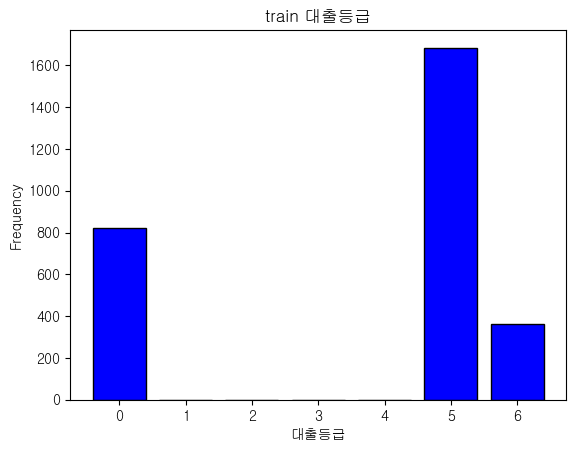

In [37]:
plt.hist(new_train_2["대출등급"], bins=range(8), align='left', rwidth=0.8, color='blue', edgecolor='black')

plt.xlabel("대출등급")
plt.ylabel("Frequency")
plt.title("train 대출등급")
plt.show()

In [38]:
new_train_2["대출등급"] = new_train_2["대출등급"].apply(lambda x:0 if x==0 else x)
new_train_2["대출등급"] = new_train_2["대출등급"].apply(lambda x:1 if x==5 else x)
new_train_2["대출등급"] = new_train_2["대출등급"].apply(lambda x:2 if x==6 else x)
new_train_2["대출등급"].unique()

array([1, 2, 0], dtype=int64)

In [39]:
X = new_train_2.drop(columns=['대출등급'])
y = new_train_2[['대출등급']]

In [40]:
cat = CatBoostRegressor()
model_2 = cat.fit(X, y)
pred = model_2.predict(X)

Learning rate set to 0.048351
0:	learn: 0.6024521	total: 3.05ms	remaining: 3.05s
1:	learn: 0.5855238	total: 5.66ms	remaining: 2.82s
2:	learn: 0.5683492	total: 8.29ms	remaining: 2.76s
3:	learn: 0.5517482	total: 11ms	remaining: 2.74s
4:	learn: 0.5360297	total: 14.2ms	remaining: 2.82s
5:	learn: 0.5227771	total: 16.6ms	remaining: 2.76s
6:	learn: 0.5087970	total: 19ms	remaining: 2.69s
7:	learn: 0.4935895	total: 21.3ms	remaining: 2.64s
8:	learn: 0.4807694	total: 23.3ms	remaining: 2.56s
9:	learn: 0.4678671	total: 25.2ms	remaining: 2.5s
10:	learn: 0.4547035	total: 27ms	remaining: 2.43s
11:	learn: 0.4436168	total: 28.8ms	remaining: 2.37s
12:	learn: 0.4326855	total: 30.6ms	remaining: 2.32s
13:	learn: 0.4210865	total: 33ms	remaining: 2.32s
14:	learn: 0.4121236	total: 35.1ms	remaining: 2.3s
15:	learn: 0.4035011	total: 37.5ms	remaining: 2.31s
16:	learn: 0.3969529	total: 39.4ms	remaining: 2.28s
17:	learn: 0.3885582	total: 42.4ms	remaining: 2.31s
18:	learn: 0.3790137	total: 44.6ms	remaining: 2.3s
19:

In [41]:
pred_2 = model_2.predict(test).flatten()
pred_2 = np.round(pred_2)
sub.loc[(sub['대출등급'] == 'G') & (pred_2 == 0) & (test["대출기간"] == 72), "대출등급"] = 0
sub.loc[(sub['대출등급'] == 'G') & (pred_2 == 1) & (test["대출기간"] == 72), "대출등급"] = 5
sub.loc[(sub['대출등급'] == 'G') & (pred_2 == 2) & (test["대출기간"] == 72), "대출등급"] = 6
sub["대출등급"].unique()

array([1, 0, 2, 5, 3, 4, 6], dtype=object)

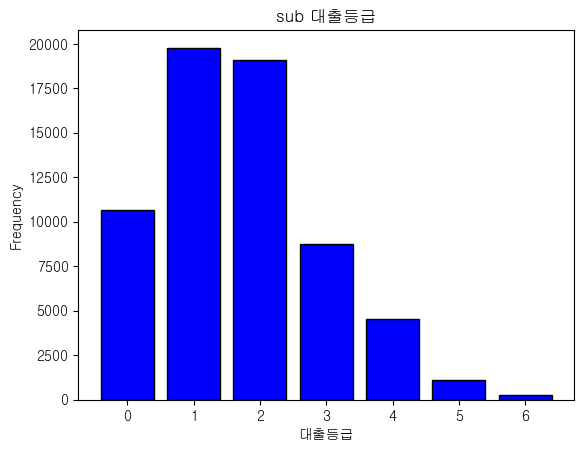

In [42]:
plt.hist(sub["대출등급"], bins=range(8), align='left', rwidth=0.8, color='blue', edgecolor='black')

plt.xlabel("대출등급")
plt.ylabel("Frequency")
plt.title("sub 대출등급")
plt.show()

In [43]:
mapping_rank = {0 : "A",1 : "B",2 : "C",3 : "D",4 : "E",5 : "F",6 : "G"}
sub["대출등급"] = sub["대출등급"].replace(mapping_rank)
sub

,ID,대출등급
0,TEST_00000,B
1,TEST_00001,B
2,TEST_00002,A
3,TEST_00003,C
4,TEST_00004,C
...,...,...
64192,TEST_64192,D
64193,TEST_64193,D
64194,TEST_64194,D
64195,TEST_64195,C


In [44]:
sub.to_csv("submission/81_4.ABC(DEFG)_BCDE(AFG)_regression_cat.csv",index=False)